<a href="https://colab.research.google.com/github/Priyo-prog/Deep-Learning-with-Tensorflow/blob/main/Transfer%20Learning%20with%20Tensorflow/transfer_learning_with_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with TensorFlow part 2: Fine Tuning**

In [1]:
# Check the GPU we are using 
!nvidia-smi

Fri Feb 25 04:58:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting the helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-25 04:58:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-25 04:58:40 (91.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import the helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get the data

This time we are going to see how we can use the pretrained models within 'tf.keras.applications' and apply them to our problem

In [4]:
# Get the 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-02-25 04:58:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   177MB/s    in 0.9s    

2022-02-25 04:58:44 (177 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train"
test_data = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_data,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.77642853e+02 1.77642853e+02 1.85642853e+02]
   [1.78875793e+02 1.81633301e+02 1.91360809e+02]
   [1.77738846e+02 1.83738846e+02 1.96167419e+02]
   ...
   [1.16261162e+02 1.25261162e+02 1.34261154e+02]
   [1.16313942e+02 1.25313942e+02 1.34313950e+02]
   [1.17525055e+02 1.26525055e+02 1.35525055e+02]]

  [[1.77642853e+02 1.77642853e+02 1.87209824e+02]
   [1.78928574e+02 1.80944046e+02 1.92897644e+02]
   [1.76048630e+02 1.82048630e+02 1.94477188e+02]
   ...
   [1.17000000e+02 1.26000000e+02 1.35000000e+02]
   [1.17055977e+02 1.26055977e+02 1.35055969e+02]
   [1.18279846e+02 1.27279846e+02 1.36279846e+02]]

  [[1.76140457e+02 1.76140457e+02 1.86140457e+02]
   [1.77033005e+02 1.79033005e+02 1.91033005e+02]
   [1.72894287e+02 1.79108582e+02 1.93537140e+02]
   ...
   [1.18000000e+02 1.27000000e+02 1.36000000e+02]
   [1.18000000e+02 1.27000000e+02 1.36000000e+02]
   [1.19000000e+02 1.28000000e+02 1.37000000e+02]]

  ...

  [[1.76926208e+02 2.03926208e+02 2.22314636e+02]
   [1

## Build Transfer Learning model using Functional API

The Sequential API is straight forward, it runs our layer in sequential order

But the Functional API gives us more flexibility with our models :- 

[Tensorflow Keras Functional API](https://www.tensorflow.org/guide/keras/functional)

In [10]:
# 1. Create bas model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs in our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't need to for EfficientNet)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220225-045857
Epoch 1/5
24/24 [==============================] - 30s 253ms/step - loss: 1.8828 - accuracy: 0.3787 - val_loss: 1.3248 - val_accuracy: 0.6957
Epoch 2/5
24/24 [==============================] - 4s 164ms/step - loss: 1.1433 - accuracy: 0.7467 - val_loss: 0.9050 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 4s 163ms/step - loss: 0.8423 - accuracy: 0.8053 - val_loss: 0.7320 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 4s 164ms/step - loss: 0.6898 - accuracy: 0.8440 - val_loss: 0.6379 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 5s 189ms/step - loss: 0.5905 - accuracy: 0.8693 - val_loss: 0.5752 - val_accuracy: 0.8701


In [11]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6109 - accuracy: 0.8392


[0.6108800768852234, 0.8392000198364258]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


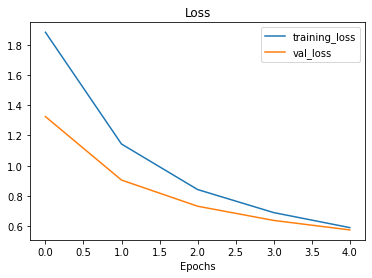

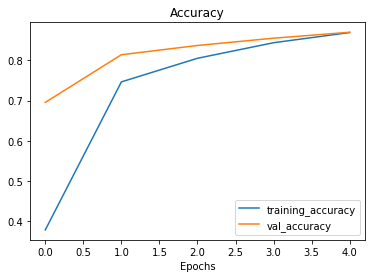

In [14]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Get a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer

We have a tensor after our model goes through 'base model' of 
shape(None, 7, 7, 1280) 

But when it passes through GlobalAveragePooling2D, it turns into 
shape(None, 1280)..

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it
to GlobalAveragePooling2D.


In [15]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [16]:
# pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # Passing the input_tensor after the layer
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [17]:
# Check the shapes of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of the global average pooled 2D tensor : {global_average_pooled_tensor}")

Shape of input tensor: (1, 4, 4, 3)
Shape of the global average pooled 2D tensor : [[-0.09368646 -0.45840448 -0.2885598 ]]


In [18]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Feature Vector

**What is a feature vector?**

Ans : A feature vector is a learned representation of the input data(a compressed form of the input data based on how model see's it)

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it goes with **1%** of the training data... how about we setup a bunch of experiments to find out:

1. 'model_1' - use feature extraction transfer learning with 1% of data with data augmentation

2. 'model_2' - use feature extraction transfer learning with 10% of the training data with data augmentation 

3. 'model_3' - use **fine-tuning** transfer learning on 10% of the training data with data augmentation.

4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation. 


Note: throught all experiments the same test dataset will be used to evaluate our model.... this ensure consistency across evaluation metrics.

In [19]:
# Download and unzip the data -  preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-02-25 04:59:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 74.125.26.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   205MB/s    in 0.6s    

2022-02-25 04:59:59 (205 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create train and test dirs 
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with ?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [22]:
# Set up the data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


* Adding data augmentation right into the model

   To add the data augmentation right into our models, we can use the layers   inside:
   * tf.keras.layers.experimental.preprocessing()

* Benefits of in-layer data augmentation

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using **model.save**, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.




In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Create data augmentation stage with horizontal flipping, rotation, zooms etc..
data_augmentation = Sequential([
 preprocessing.RandomFlip("horizontal"),
 preprocessing.RandomRotation(0.2),
 preprocessing.RandomZoom(0.2),
 preprocessing.RandomHeight(0.2),
 preprocessing.RandomWidth(0.2),
 # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in                                      
], name="data_augmentation")

## Visualize out data augmentation layer

In [24]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)

10_food_classes_1_percent/train/ramen


In [25]:
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

10_food_classes_1_percent/train/ramen/196184.jpg


[[[ 31  21  12]
  [ 52  43  34]
  [ 92  83  74]
  ...
  [251 251 255]
  [253 252 255]
  [255 254 255]]

 [[ 34  24  15]
  [ 34  24  15]
  [ 53  43  34]
  ...
  [251 251 255]
  [255 254 255]
  [249 248 254]]

 [[ 38  25  17]
  [ 31  18  10]
  [ 30  17   9]
  ...
  [242 242 250]
  [253 253 255]
  [253 252 255]]

 ...

 [[161 100  37]
  [152  92  30]
  [149  90  32]
  ...
  [152 109  74]
  [140  97  62]
  [124  81  46]]

 [[159  98  35]
  [150  90  30]
  [148  89  33]
  ...
  [156 113  78]
  [150 107  72]
  [137  94  59]]

 [[152  90  29]
  [145  85  25]
  [148  87  32]
  ...
  [158 115  81]
  [155 115  79]
  [145 105  69]]]


Text(0.5, 1.0, 'Original random image from class : ramen')

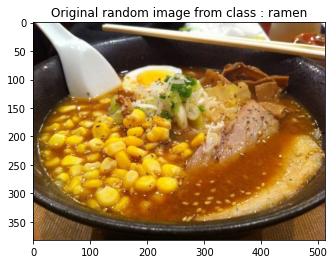

In [26]:
# Visualize the random image
img = mpimg.imread(random_image_path)
print(img)
plt.imshow(img)
plt.title(f'Original random image from class : {target_class}')
#plt.axis(emit=False)

Text(0.5, 1.0, 'Augmented random image from class: ramen')

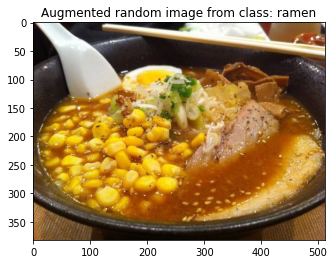

In [27]:
# Now let's plot our augmented image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.) #  
plt.title(f"Augmented random image from class: {target_class}")
#plt.axis(False)

## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation (only 7 images per class for training)

In [28]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)

# Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Keeping the transfer learning base model intact

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in the data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # passing the input to the model api class

# Puta  dense layer on as the output 
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learninig",
                                                                       experiment_name="1_percent_data_aug")]) # from helper functions                                                                       
                                                                       

Saving TensorBoard log files to: transfer_learninig/1_percent_data_aug/20220225-050004
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4035 - accuracy: 0.1429 - val_loss: 2.2079 - val_accuracy: 0.1957
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1700 - accuracy: 0.2857 - val_loss: 2.0900 - val_accuracy: 0.2730
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9993 - accuracy: 0.4429 - val_loss: 2.0194 - val_accuracy: 0.3224
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8276 - accuracy: 0.5000 - val_loss: 1.8980 - val_accuracy: 0.4095
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6813 - accuracy: 0.5429 - val_loss: 1.8100 - val_accuracy: 0.4671


In [29]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 79ms/step - loss: 1.8250 - accuracy: 0.4492


[1.8249597549438477, 0.44920000433921814]

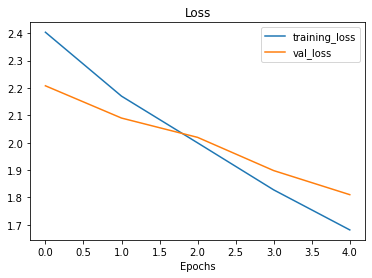

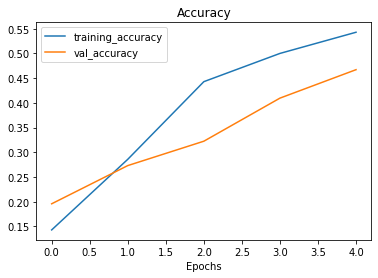

In [31]:
# How do the model with 1% of the training data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)


## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [32]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
#unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [33]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# Create Model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build Data Augmentation Layer
data_augmentation = Sequential([
 preprocessing.RandomFlip("horizontal"),
 preprocessing.RandomHeight(0.2),
 preprocessing.RandomWidth(0.2),
 preprocessing.RandomZoom(0.2),
 preprocessing.RandomRotation(0.2),
 #preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in                                
], name="data_augmentation")

# Setup the input shape of our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images

# pass augmented images to base model but keep it in inference mode, 
# this also ensures batchnorm layers don't get updates
x= base_model(x, training=False) # Result is a multidimensional tensor

# compress the multidimensional tensor to a feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create a model checkpoint callback

* Callbacks are which can add helpful functionality to your models during training,evaluation or inference

* ModelCheckpoint callback intermediately saves our model ( The full model or just the weights) during training. This is useful so we can come and start where we left off.

In [35]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1 # do you want to see the output or not
                                                         )

### Fit the model 2 passing in the model checkpoint callback

In [36]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                                 experiment_name="10_percent_data_aug"),
                                                                                  checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220225-050049
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0196 - accuracy: 0.3387
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 564ms/step - loss: 2.0196 - accuracy: 0.3387 - val_loss: 1.5050 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3743 - accuracy: 0.6787
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 444ms/step - loss: 1.3743 - accuracy: 0.6787 - val_loss: 1.0566 - val_accuracy: 0.7533
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0779 - accuracy: 0.7427
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 408ms/step - loss: 1.0779 - accuracy: 0.7427 - val_loss: 0.8438 - val_accuracy: 0.7961
E

In [37]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.6109 - accuracy: 0.8392


[0.6108800768852234, 0.8392000198364258]

In [38]:
# What were model_2 test_results?
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.7012 - accuracy: 0.8048


[0.7011785507202148, 0.8047999739646912]

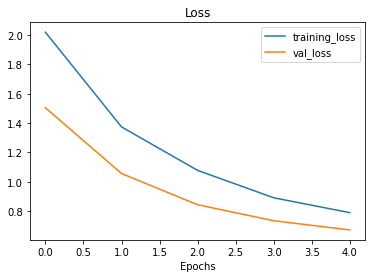

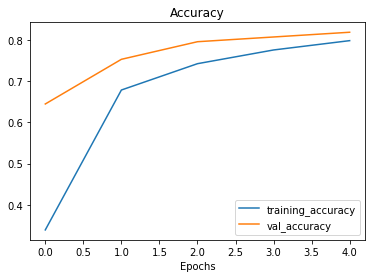

In [39]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [40]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [41]:
# load in the saved model weights and evaluate model
results_10_percent_data_aug = model_2.load_weights(checkpoint_path)
results_10_percent_data_aug

In [42]:
# Evaluate the model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.7012 - accuracy: 0.8048


In [43]:
# If the results are from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [48]:
# Check to see if the loaded model results are very close to our results are very close to our previously non-loaded model results
import numpy as np
#np.isclose(np.array(results_10_percent_data_aug, dtype="float32"), np.array(loaded_weights_model_results))

## Model 3 : Fine tuning and existing model on 10% of the data

**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [49]:
# Layers in a loaded model. Model 3 will be the fine tuned version of Model 2
model_2.layers

In [50]:
# Are these layers trainable ?
for layers in model_2.layers:
  print(layers, layers.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f32b82d54d0> True
<keras.engine.sequential.Sequential object at 0x7f32baa521d0> True
<keras.engine.functional.Functional object at 0x7f32ba5ee450> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f32b82779d0> True
<keras.layers.core.dense.Dense object at 0x7f32b8282590> True


In [51]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


We have already mentioned in base model that it won't be trained. **'base_model.trainable = False'**. Now we are trying to find a way to train atleast top 10 layers of the base model trainable.

In [53]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainabel = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models everytime we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate so that it doesn't overfit
                metrics=["accuracy"])

**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10X.

In [54]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there ?
print(len(model_2.trainable_variables))

2


In [ ]:
# Next Lesson 19...